In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os


base_dir = "/content/drive/MyDrive/25MRes_SB" #change to your own folder

#name relevant files for analysis
files = {
    "cohort1": "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_1.xlsx",
    "cohort2": "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_2.xlsx",
    "cohort2_csv" : "250827_cohort2_weightlogs.csv"
}

colours = {
            "ctrl_Exc": "#778899",
            "ctrl_Inh": "#BC8F8F",
            "LPS_Exc": "#3366CC",
            "LPS_Inh": "#FF6666"
        }

def load_data(base_dir, file, sheet_name=None):
    file_path = os.path.join(base_dir, file)

    if sheet_name:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
        df = df.drop(0).reset_index(drop=True) #drop title row
        df.columns = df.iloc[1]
        df = df.drop(1).reset_index(drop=True) #drop row that names the columns
        df = df.dropna()

        return df
    else:
        sheets = ["Initial Weights", "Treatment Allocations",
                  "Weight Logs" #not in supported format for analysis
                  ] #change sheets if different
        df = pd.read_excel(file_path, sheet_name=sheets)
        return df

baseline_weights = load_data(base_dir, files["cohort2"], sheet_name="Initial Weights") # column 1 is average of three baseline weights

treatment_allocations = load_data(base_dir, files["cohort2"], sheet_name="Treatment Allocations")

mouse_ids = treatment_allocations[["ID", "Sex", "Treatment"]].copy()


In [ ]:
file_path = os.path.join(base_dir, files["cohort2_csv"])

all_weights = pd.read_csv(file_path, header=1) #dropping original column names

# Clean the data - handle '-' and '/2', '/3' patterns
def clean_weight_value(val):
    if pd.isna(val) or val == '-' or val == '---':
        return np.nan
    if isinstance(val, str):
        if '/' in val:
            return float(val.split('/')[0])
        return float(val)
    return val

weight_cols = [col for col in all_weights.columns if col.startswith('Weight_')]
weight_cols_except_1 = [col for col in weight_cols if col != 'Weight_1']

for col in weight_cols:
    all_weights[col] = all_weights[col].apply(clean_weight_value) #clean data
    new_col_name = col.replace('Weight_', 'pct_change_')
    all_weights[new_col_name] = (((all_weights[col] - all_weights['Weight_1']) / all_weights["Weight_1"]) *100).round(2) #calculate baseline change

all_weights_df = all_weights.merge(mouse_ids, on='ID', how= 'inner') #dataframe with all essential info

id_vars = ["ID", "Sex", "Treatment"]

change_cols = [col for col in all_weights.columns if col.startswith('pct_change_')]

df_long = all_weights_df.melt(
    id_vars=id_vars,
    value_vars=change_cols,
    var_name='Day',
    value_name='pct_change'
)

df_long["Day"] = df_long["Day"].str.extract(r'(\d+)').astype(int)
df_long['Group'] = df_long['Sex'] + '_' + df_long['Treatment'].str.split(',').str[0]

summary = df_long.groupby(['Group', 'Day'])['pct_change'].agg([
    ('mean', 'mean'),
    ('sem', lambda x: x.sem()),
    ('n', 'count')
]).reset_index()



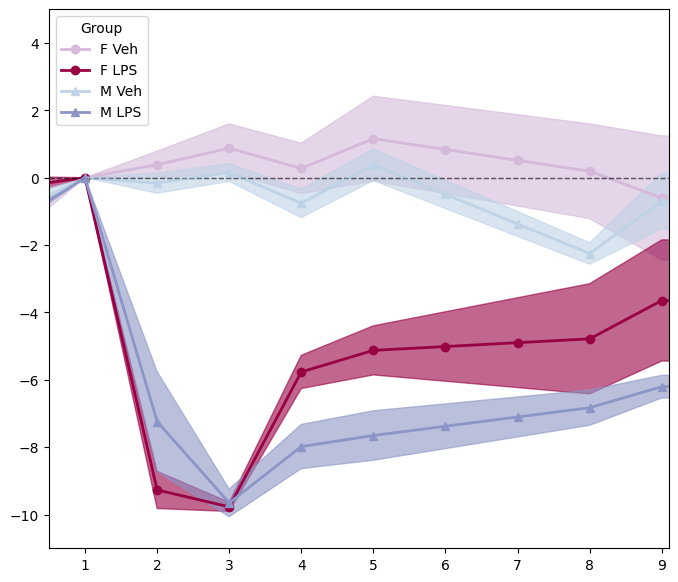

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))

colors = {'F_Veh': '#d4b9da', 'F_LPS': '#980043',
          'M_Veh': '#bfd3e6', 'M_LPS': '#8c96c6'}

markers = {'F_Veh': 'o', 'F_LPS': 'o', 'M_Veh': '^', 'M_LPS': '^'}

all_days = np.arange(summary['Day'].min(), summary['Day'].max() + 1) #make up for missing body weight measurements

for group in ['F_Veh', 'F_LPS', 'M_Veh', 'M_LPS']:
    data = summary[summary['Group'] == group].copy()
    data = data.sort_values('Day').set_index('Day')

    data = data.reindex(all_days)
    data['mean'] = data['mean'].interpolate()
    data['sem'] = data['sem'].interpolate()

    ax.plot(all_days, data['mean'],
            label=group.replace('_', ' '),
            color=colors[group],
            marker=markers[group],
            linewidth=2, markersize=6)

    ax.fill_between(all_days,
                    data['mean'] - data['sem'],
                    data['mean'] + data['sem'],
                    color=colors[group], alpha=0.6)
    ax.set_ylim(-11, 5)
    ax.set_xticks(range(1, 10))
    ax.set_xlim(0.5, 9.1)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.2, linewidth=1)
    ax.legend(title='Group', loc='best', frameon=True, fancybox=True)


In [ ]:

# Statistical comparisons for each timepoint
p_values_female = []
p_values_male = []

for day in range(1, 9):
    # Female comparison (PBS vs LPS)
    f_pbs = df_long[(df_long['Day'] == day) & (df_long['Group'] == 'F_Veh')]['pct_Change'].dropna()
    f_lps = df_long[(df_long['Day'] == day) & (df_long['Group'] == 'F_LPS')]['pct_Change'].dropna()
    if len(f_pbs) > 0 and len(f_lps) > 0:
        _, p = stats.mannwhitneyu(f_pbs, f_lps)
        p_values_female.append(p)

    # Male comparison (PBS vs LPS)
    m_pbs = df_long[(df_long['Day'] == day) & (df_long['Group'] == 'M_Veh')]['pct_Change'].dropna()
    m_lps = df_long[(df_long['Day'] == day) & (df_long['Group'] == 'M_LPS')]['pct_Change'].dropna()
    if len(m_pbs) > 0 and len(m_lps) > 0:
        _, p = stats.mannwhitneyu(m_pbs, m_lps)
        p_values_male.append(p)

# Apply Benjamini-Hochberg correction
if p_values_female:
    _, p_corrected_female, _, _ = multipletests(p_values_female, method='fdr_bh')
if p_values_male:
    _, p_corrected_male, _, _ = multipletests(p_values_male, method='fdr_bh')

# Add significance markers
y_max = ax.get_ylim()[1]
for i, day in enumerate(range(1, 9)):
    if i < len(p_corrected_female) and p_corrected_female[i] < 0.05:
        ax.text(day, y_max * 0.95, '*', ha='center', fontsize=12, color=colors['F_LPS'])
    if i < len(p_corrected_male) and p_corrected_male[i] < 0.05:
        ax.text(day, y_max * 0.90, '*', ha='center', fontsize=12, color=colors['M_LPS'])

# Formatting
ax.set_xlabel('Days Post-Injection', fontsize=12)
ax.set_ylabel('Body Weight Change from Baseline (%)', fontsize=12)
ax.set_title('Body Weight Changes Following LPS Treatment', fontsize=14)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax.set_xticks(range(1, 9))
ax.grid(True, alpha=0.3)
ax.legend(title='Group', loc='best', frameon=True, fancybox=True)

plt.tight_layout()
plt.show()

# Print statistical summary
print("BH-corrected p-values (LPS vs PBS):")
print(f"Female comparisons: {p_corrected_female}")
print(f"Male comparisons: {p_corrected_male}")

KeyError: 'Pct_Change'

In [ ]:
# Get all weight columns

# Create baseline change columns
for col in weight_cols:
    new_col_name = col.replace('Weight_', 'Change_')
    all_weights[new_col_name] = all_weights[col] / all_weights['Weight_0']

# Or if you want percentage change:
for col in weight_cols:
    new_col_name = col.replace('Weight_', 'PctChange_')
    all_weights[new_col_name] = (all_weights[col] / all_weights['Weight_0'] - 1) * 100

In [ ]:
import pandas as pd
import os

base_dir = "/content/drive/MyDrive/25MRes_SB"

files = {
    "cohort1": "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_1.xlsx",
    "cohort2": "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_2.xlsx"
}

def load_data(base_dir, file, sheet_name=None):
    file_path = os.path.join(base_dir, file)
    sheets = ["Initial Weights", "Treatment Allocations", "Weight Logs"]
    df = pd.read_excel(file_path, sheet_name=sheets)
    return df


In [ ]:
initial_weights = load_data(base_dir, files["cohort2"], sheet_name= "Initial Weights")
initial_weights

{'Initial Weights':    Eli Lilly - Experiment 1 (Cohort 2) - LPS (0.1mg/kg) / Initial Weights  \
 0                                                 NaN                       
 1                                                  ID                       
 2                                                   1                       
 3                                                   2                       
 4                                                   3                       
 5                                                   4                       
 6                                                   5                       
 7                                                   6                       
 8                                                   7                       
 9                                                   8                       
 10                                                  9                       
 11                                          

In [ ]:
import pandas as pd
import os

base_dir = "/content/drive/MyDrive/25MRes_SB" #change this to your research folder

files = {
        "cohort1" : "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_1.xlsx",
        "cohort2" : "250827experiment_1_LPS_IF_General_Mouse_Info_Cohort_2.xlsx"
        }

def load_data(base_dir, file, sheet_name=None):
    file_path = os.path.join(base_dir, file)
    if sheet_name:
        df = pd.read_excel(file_path, sheet_name=sheet_name,
                           skiprows=1 #remove title column from original spreadsheet, as not needed in analysis
                           )
    sheets = ["Initial Weights", "Treatment Allocations", "Weight Logs"] #change depending on the names of Excel sheets

    # Return dictionary of all sheets when no sheet_name specified
    return {sheet: pd.read_excel(file_path, sheet_name=sheet)
            for sheet in sheets}

initial_weights = load_data(base_dir, files["cohort2"], sheet_name=0)
initial_weights

{'Initial Weights':    Eli Lilly - Experiment 1 (Cohort 2) - LPS (0.1mg/kg) / Initial Weights  \
 0                                                 NaN                       
 1                                                  ID                       
 2                                                   1                       
 3                                                   2                       
 4                                                   3                       
 5                                                   4                       
 6                                                   5                       
 7                                                   6                       
 8                                                   7                       
 9                                                   8                       
 10                                                  9                       
 11                                          

In [ ]:
import pandas as pd

def load_cohort_data(file_path, sheet_name=None):

    if sheet_name:
        return pd.read_excel(file_path, sheet_name=sheet_name)

    # Load all sheets
    sheets = ["Initial Weights", "Treatment Allocations", "Weight Logs"]
    return {sheet: pd.read_excel(file_path, sheet_name=sheet)
            for sheet in sheets}

# Usage for cohort2, first sheet
initial_weights = load_cohort_data("cohort2.xlsx", "Initial Weights")

# Or load all
cohort2_data = load_cohort_data("cohort2.xlsx")

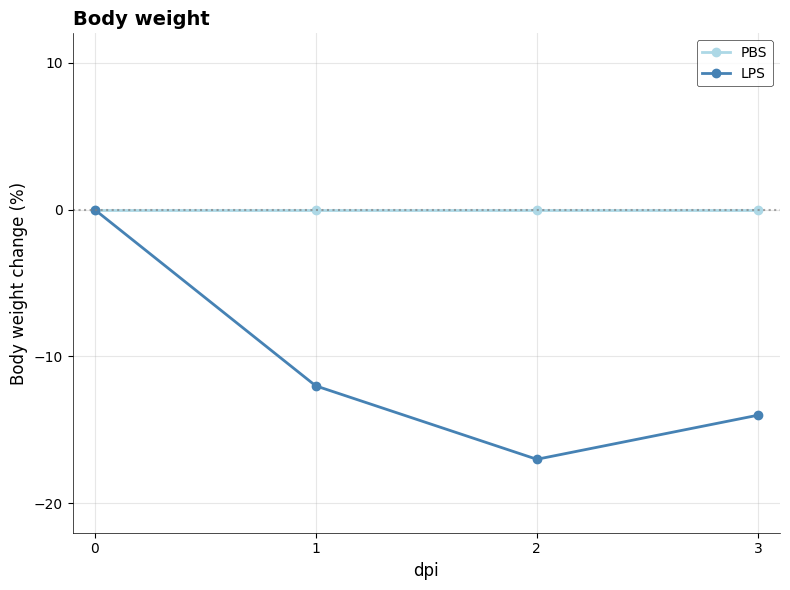


Fake data used:
PBS: [0, 0, 0, 0]
LPS: [0, -12, -17, -14]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

days = [0, 1, 2, 3]
pbs_data = [0, 0, 0, 0]
lps_data = [0, -12, -17, -14]


fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(days, pbs_data, 'o-', color='lightblue', linewidth=2, markersize=6, label='PBS')
ax.plot(days, lps_data, 'o-', color='steelblue', linewidth=2, markersize=6, label='LPS')


ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7)


ax.set_xlabel('dpi', fontsize=12)
ax.set_ylabel('Body weight change (%)', fontsize=12)
ax.set_title('Body weight', fontsize=14, fontweight='bold', loc='left')

# Set axis limits and ticks
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-22, 12)
ax.set_xticks(days)
ax.set_yticks(range(-20, 15, 10))

# Add grid
ax.grid(True, alpha=0.3)

# Add legend with custom styling
legend = ax.legend(frameon=True, fancybox=True, shadow=False)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)

# Add injection arrows and labels
#arrow_props = dict(arrowstyle='->', lw=1.5, color='black')
#ax.annotate('1st', xy=(1, -20), xytext=(1, -22),
            #ha='center', va='top', fontsize=10,
            #arrowprops=arrow_props)


# Clean up the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout()
plt.show()

# Save the figure
#plt.savefig('body_weight_fake.png', dpi=300, bbox_inches='tight')

print("\nFake data used:")
print(f"PBS: {pbs_data}")
print(f"LPS: {lps_data}")

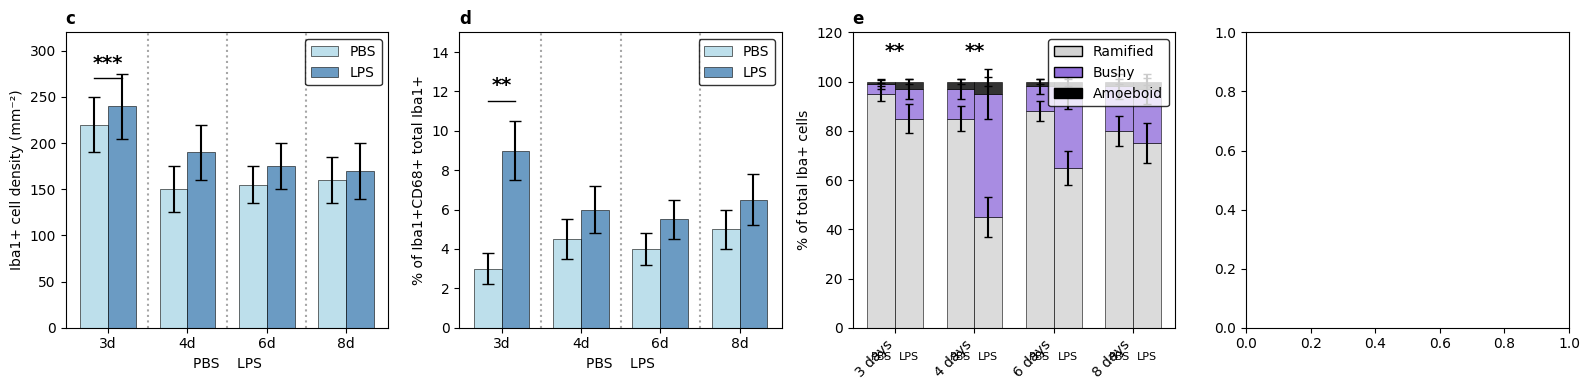

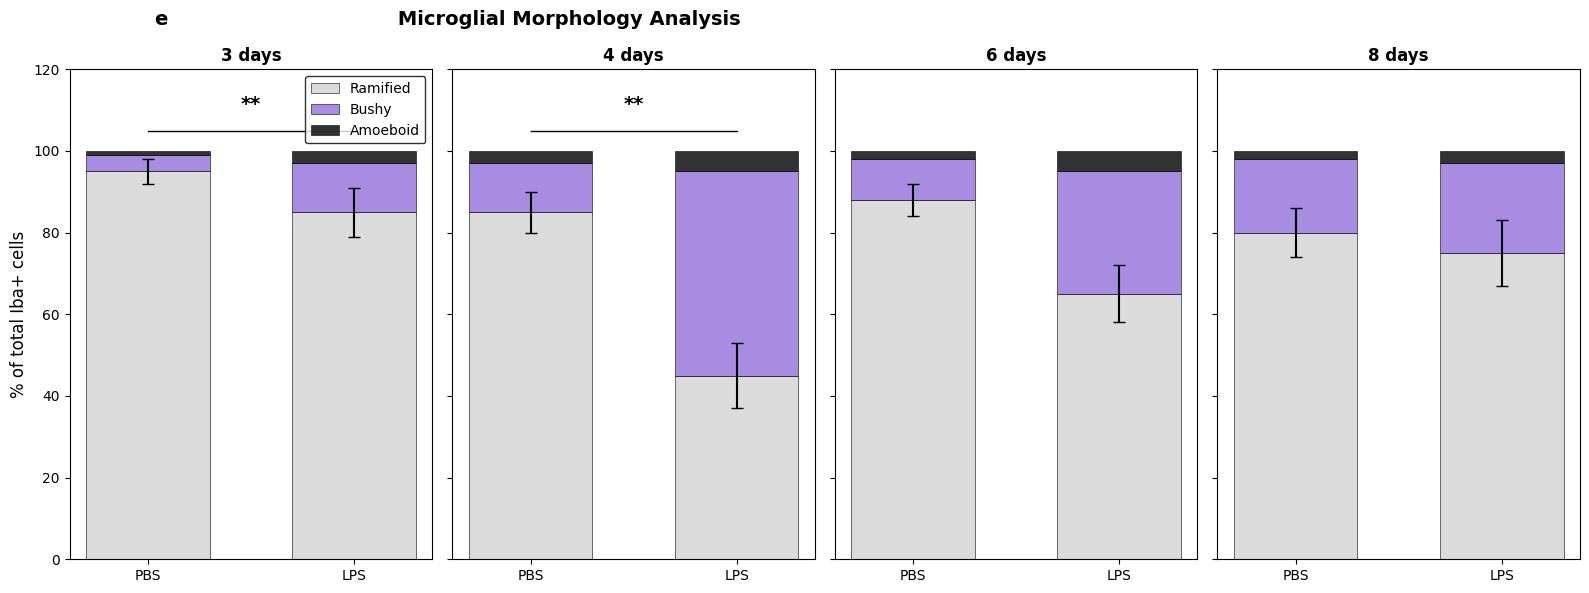

Plots created! You can modify the fake data values to match your actual results.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style
plt.style.use('default')
sns.set_palette("Set2")

# Create figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# ===============================
# PLOT C: Iba1+ cell density
# ===============================

# Fake data for plot c
days = ['3d', '4d', '6d', '8d']
pbs_density = [220, 150, 155, 160]
lps_density = [240, 190, 175, 170]
pbs_density_err = [30, 25, 20, 25]
lps_density_err = [35, 30, 25, 30]

x_pos = np.arange(len(days))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, pbs_density, width, yerr=pbs_density_err,
                   label='PBS', alpha=0.8, capsize=4, color='lightblue', edgecolor='black', linewidth=0.5)
bars2 = axes[0].bar(x_pos + width/2, lps_density, width, yerr=lps_density_err,
                   label='LPS', alpha=0.8, capsize=4, color='steelblue', edgecolor='black', linewidth=0.5)

axes[0].set_ylabel('Iba1+ cell density (mm⁻²)', fontsize=10)
axes[0].set_xlabel('PBS    LPS', fontsize=10)
axes[0].set_title('c', fontweight='bold', fontsize=12, loc='left')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(days)
axes[0].set_ylim(0, 320)
axes[0].legend(frameon=True, edgecolor='black')

# Add significance stars
axes[0].text(0, 280, '***', ha='center', fontsize=14, fontweight='bold')
axes[0].plot([0-width/2, 0+width/2], [270, 270], 'k-', linewidth=1)

# Add dotted lines between day groups
for i in range(len(days)-1):
    axes[0].axvline(x=i+0.5, color='gray', linestyle=':', alpha=0.7)

# ===============================
# PLOT D: % of Iba1+CD68+ total Iba1+
# ===============================

pbs_cd68 = [3, 4.5, 4, 5]
lps_cd68 = [9, 6, 5.5, 6.5]
pbs_cd68_err = [0.8, 1, 0.8, 1]
lps_cd68_err = [1.5, 1.2, 1, 1.3]

bars3 = axes[1].bar(x_pos - width/2, pbs_cd68, width, yerr=pbs_cd68_err,
                   label='PBS', alpha=0.8, capsize=4, color='lightblue', edgecolor='black', linewidth=0.5)
bars4 = axes[1].bar(x_pos + width/2, lps_cd68, width, yerr=lps_cd68_err,
                   label='LPS', alpha=0.8, capsize=4, color='steelblue', edgecolor='black', linewidth=0.5)

axes[1].set_ylabel('% of Iba1+CD68+ total Iba1+', fontsize=10)
axes[1].set_xlabel('PBS    LPS', fontsize=10)
axes[1].set_title('d', fontweight='bold', fontsize=12, loc='left')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(days)
axes[1].set_ylim(0, 15)
axes[1].legend(frameon=True, edgecolor='black')

# Add significance stars
axes[1].text(0, 12, '**', ha='center', fontsize=14, fontweight='bold')
axes[1].plot([0-width/2, 0+width/2], [11.5, 11.5], 'k-', linewidth=1)

# Add dotted lines
for i in range(len(days)-1):
    axes[1].axvline(x=i+0.5, color='gray', linestyle=':', alpha=0.7)

# ===============================
# PLOT E: Microglial morphology over time - split into 2 subplots
# ===============================

# Remove the 3rd axis and create 2 subplots for plot e
axes[2].remove()
axes[3].remove()

# Create new subplots for the morphology data
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1])
ax_e1 = fig.add_subplot(gs[2])
ax_e2 = fig.add_subplot(gs[3])

# Days and treatments for morphology
morph_days = ['3 days', '4 days', '6 days', '8 days']
treatments = ['PBS', 'LPS']

# Fake morphology data (percentages)
# Ramified (gray), Bushy (purple), Amoeboid (black)
pbs_ramified = [95, 85, 88, 80]
pbs_bushy = [4, 12, 10, 18]
pbs_amoeboid = [1, 3, 2, 2]

lps_ramified = [85, 45, 65, 75]
lps_bushy = [12, 50, 30, 22]
lps_amoeboid = [3, 5, 5, 3]

# Errors
pbs_ramified_err = [3, 5, 4, 6]
pbs_bushy_err = [2, 4, 3, 5]
pbs_amoeboid_err = [0.5, 1, 1, 1]

lps_ramified_err = [6, 8, 7, 8]
lps_bushy_err = [4, 10, 6, 6]
lps_amoeboid_err = [1, 2, 2, 1.5]

# Colors for morphology types
colors = ['lightgray', 'mediumpurple', 'black']

# Plot for each day
x_positions = [0, 1, 2, 3]
bar_width = 0.35

for i, day in enumerate(morph_days):
    # PBS data
    ax_e1.bar(i - bar_width/2, pbs_ramified[i], bar_width, yerr=pbs_ramified_err[i],
              color=colors[0], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)
    ax_e1.bar(i - bar_width/2, pbs_bushy[i], bar_width, bottom=pbs_ramified[i], yerr=pbs_bushy_err[i],
              color=colors[1], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)
    ax_e1.bar(i - bar_width/2, pbs_amoeboid[i], bar_width, bottom=np.array(pbs_ramified[i])+np.array(pbs_bushy[i]),
              yerr=pbs_amoeboid_err[i], color=colors[2], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)

    # LPS data
    ax_e1.bar(i + bar_width/2, lps_ramified[i], bar_width, yerr=lps_ramified_err[i],
              color=colors[0], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)
    ax_e1.bar(i + bar_width/2, lps_bushy[i], bar_width, bottom=lps_ramified[i], yerr=lps_bushy_err[i],
              color=colors[1], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)
    ax_e1.bar(i + bar_width/2, lps_amoeboid[i], bar_width, bottom=np.array(lps_ramified[i])+np.array(lps_bushy[i]),
              yerr=lps_amoeboid_err[i], color=colors[2], alpha=0.8, capsize=3, edgecolor='black', linewidth=0.5)

# Customize plot e
ax_e1.set_title('e', fontweight='bold', fontsize=12, loc='left')
ax_e1.set_ylabel('% of total Iba+ cells', fontsize=10)
ax_e1.set_xticks(x_positions)
ax_e1.set_xticklabels(morph_days, rotation=45, ha='right')
ax_e1.set_ylim(0, 120)

# Add PBS/LPS labels
for i in x_positions:
    ax_e1.text(i - bar_width/2, -10, 'PBS', ha='center', va='top', fontsize=8)
    ax_e1.text(i + bar_width/2, -10, 'LPS', ha='center', va='top', fontsize=8)

# Add significance stars
ax_e1.text(0, 110, '**', ha='center', fontsize=14, fontweight='bold')
ax_e1.text(1, 110, '**', ha='center', fontsize=14, fontweight='bold')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[0], edgecolor='black', label='Ramified'),
                   Patch(facecolor=colors[1], edgecolor='black', label='Bushy'),
                   Patch(facecolor=colors[2], edgecolor='black', label='Amoeboid')]
ax_e1.legend(handles=legend_elements, loc='upper right', frameon=True, edgecolor='black')

# Since we don't have enough space, let's use the second axis for a cleaner version
# Or we can create a separate figure for better visualization

plt.tight_layout()
plt.show()

# ===============================
# ALTERNATIVE: Separate figure for morphology data with better layout
# ===============================

fig2, axes2 = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

days_labels = ['3 days', '4 days', '6 days', '8 days']

for i, (ax, day_label) in enumerate(zip(axes2, days_labels)):
    # Data for this specific day
    pbs_data = [pbs_ramified[i], pbs_bushy[i], pbs_amoeboid[i]]
    lps_data = [lps_ramified[i], lps_bushy[i], lps_amoeboid[i]]

    pbs_err = [pbs_ramified_err[i], pbs_bushy_err[i], pbs_amoeboid_err[i]]
    lps_err = [lps_ramified_err[i], lps_bushy_err[i], lps_amoeboid_err[i]]

    x_pos = [0, 1]  # PBS, LPS
    width = 0.6

    # Stacked bars
    bottom_pbs = [0, pbs_data[0], pbs_data[0] + pbs_data[1]]
    bottom_lps = [0, lps_data[0], lps_data[0] + lps_data[1]]

    for j, (color, label) in enumerate(zip(colors, ['Ramified', 'Bushy', 'Amoeboid'])):
        ax.bar(0, pbs_data[j], width, bottom=bottom_pbs[j], yerr=pbs_err[j] if j == 0 else None,
               color=color, alpha=0.8, capsize=4, edgecolor='black', linewidth=0.5,
               label=label if i == 0 else "")
        ax.bar(1, lps_data[j], width, bottom=bottom_lps[j], yerr=lps_err[j] if j == 0 else None,
               color=color, alpha=0.8, capsize=4, edgecolor='black', linewidth=0.5)

    ax.set_title(day_label, fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['PBS', 'LPS'])
    ax.set_ylim(0, 120)

    if i == 0:
        ax.set_ylabel('% of total Iba+ cells', fontsize=12)

    # Add significance if needed
    if i in [0, 1]:  # 3 days and 4 days show significance
        ax.text(0.5, 110, '**', ha='center', fontsize=14, fontweight='bold')
        ax.plot([0, 1], [105, 105], 'k-', linewidth=1)

# Add overall title and legend
fig2.suptitle('e                                  Microglial Morphology Analysis', fontsize=14, fontweight='bold', x=0.1, ha='left')
axes2[0].legend(loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

print("Plots created! You can modify the fake data values to match your actual results.")